## 1. Import Required Libraries

In [1]:
# ==============================================================================
# IMPORT LIBRARIES
# ==============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for clustering and preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# For optimal cluster selection (Elbow method visualization)
from sklearn.decomposition import PCA

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load and Prepare Data

In [2]:
# ==============================================================================
# LOAD PROCESSED DATASET
# ==============================================================================

# Define path to the processed data file
DATA_PATH = '../data/processed/processed_data.csv'

# Load the dataset with Date as the index for time series analysis
df = pd.read_csv(DATA_PATH, parse_dates=['Date'], index_col='Date')

# Display basic information about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"\nColumns:\n{list(df.columns)}")

DATASET OVERVIEW
Shape: 1668 rows × 35 columns
Date Range: 1872-02-01 to 2023-08-01

Columns:
['SP500', 'Dividend', 'Earnings', 'Consumer Price Index', 'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings', 'PE10', 'return_1m', 'return_3m', 'return_12m', 'SP500_lag_1', 'SP500_lag_3', 'SP500_lag_12', 'Real Price_lag_1', 'Real Price_lag_3', 'Real Price_lag_12', 'PE10_lag_1', 'PE10_lag_3', 'PE10_lag_12', 'Dividend_lag_1', 'Dividend_lag_3', 'Dividend_lag_12', 'Earnings_lag_1', 'Earnings_lag_3', 'Earnings_lag_12', 'Consumer Price Index_lag_1', 'Consumer Price Index_lag_3', 'Consumer Price Index_lag_12', 'Long Interest Rate_lag_1', 'Long Interest Rate_lag_3', 'Long Interest Rate_lag_12', 'target_price_next', 'target_direction']


In [3]:
# ==============================================================================
# PREPARE FEATURES FOR CLUSTERING
# ==============================================================================

# Define columns to exclude from clustering (target variables)
# These are the prediction targets, not features for regime identification
TARGET_COLS = ['target_price_next', 'target_direction']

# Select only feature columns for clustering
feature_cols = [col for col in df.columns if col not in TARGET_COLS]

# Create a copy of feature data
X = df[feature_cols].copy()

# Check for any missing values and handle them
print(f"Missing values before handling: {X.isnull().sum().sum()}")

# Drop rows with missing values (if any)
X = X.dropna()
print(f"Samples after removing NaN: {len(X)}")

# Display feature statistics
print(f"\nNumber of features for clustering: {len(feature_cols)}")
X.describe()

Missing values before handling: 0
Samples after removing NaN: 1668

Number of features for clustering: 33


,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,return_1m,...,Dividend_lag_12,Earnings_lag_1,Earnings_lag_3,Earnings_lag_12,Consumer Price Index_lag_1,Consumer Price Index_lag_3,Consumer Price Index_lag_12,Long Interest Rate_lag_1,Long Interest Rate_lag_3,Long Interest Rate_lag_12
count,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,...,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000
mean,3.977779,2.035602,2.576629,1.115897,-0.062469,1.758243,0.875317,1.040055,0.376244,0.011897,...,2.066043,2.587340,2.589117,2.489922,1.118634,1.124156,1.150473,-0.061987,-0.060761,-0.052465
std,9.773988,4.964920,6.362419,2.470213,0.958367,4.125691,2.276394,2.625816,1.243429,1.001646,...,5.006341,6.382182,6.380297,6.135510,2.475208,2.485274,2.533813,0.958482,0.958729,0.961335
min,-0.575519,-0.694498,-0.670442,-0.711979,-1.667911,-1.242226,-2.543473,-1.839667,-2.434188,-5.689022,...,-0.631491,-0.669872,-0.639175,-0.631796,-0.712208,-0.712683,-0.715213,-1.667857,-1.667750,-1.668051
25%,-0.510906,-0.538872,-0.562949,-0.591339,-0.616296,-0.663361,-0.746713,-0.716115,-0.339933,-0.359839,...,-0.538500,-0.562045,-0.560372,-0.554156,-0.591014,-0.590366,-0.587615,-0.616156,-0.615816,-0.613123
50%,-0.382073,-0.350672,-0.379038,-0.189719,-0.348196,-0.135253,0.194528,0.064994,0.410039,0.027825,...,-0.350580,-0.377562,-0.377747,-0.379795,-0.193730,-0.211246,-0.232817,-0.348035,-0.345556,-0.337925
75%,1.741226,2.134833,2.069234,2.437738,0.165142,2.074964,1.814806,1.638698,1.067834,0.409603,...,2.163095,2.078324,2.088857,2.143722,2.444260,2.456635,2.500597,0.166384,0.176253,0.204133
max,56.088350,24.173217,35.589673,8.511433,4.442263,21.617786,9.427087,13.282087,4.467995,8.083715,...,24.813285,35.703000,35.934954,36.794643,8.544641,8.581215,8.780696,4.442815,4.444278,4.461370


In [4]:
# ==============================================================================
# SCALE FEATURES FOR K-MEANS
# ==============================================================================

# K-Means is distance-based, so we need to standardize features
# This ensures all features contribute equally to distance calculations

# Initialize the StandardScaler (zero mean, unit variance)
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier manipulation
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

print("✅ Features scaled successfully!")
print(f"\nScaled data shape: {X_scaled_df.shape}")
print(f"Mean (should be ~0): {X_scaled.mean():.6f}")
print(f"Std (should be ~1): {X_scaled.std():.6f}")

✅ Features scaled successfully!

Scaled data shape: (1668, 33)
Mean (should be ~0): 0.000000
Std (should be ~1): 1.000000


## 3. Determine Optimal Number of Clusters

In [5]:
# ==============================================================================
# ELBOW METHOD - Find optimal number of clusters
# ==============================================================================

# The Elbow Method helps identify the optimal number of clusters
# by plotting the within-cluster sum of squares (inertia) vs number of clusters
# The "elbow" point indicates diminishing returns from adding more clusters

# Define range of clusters to test
K_RANGE = range(2, 11)  # Test from 2 to 10 clusters

# Lists to store metrics for each k value
inertias = []           # Within-cluster sum of squares
silhouette_scores = []  # Silhouette coefficient (-1 to 1, higher is better)
calinski_scores = []    # Calinski-Harabasz index (higher is better)

print("Evaluating cluster counts...\n")

# Iterate through different cluster counts
for k in K_RANGE:
    # Initialize K-Means with current k value
    # n_init=10: Run algorithm 10 times with different seeds
    # random_state: Ensures reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit the model
    kmeans.fit(X_scaled)
    
    # Store inertia (sum of squared distances to nearest cluster center)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (measures how similar points are to own cluster)
    sil_score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    # Calculate Calinski-Harabasz score (ratio of between/within cluster dispersion)
    cal_score = calinski_harabasz_score(X_scaled, kmeans.labels_)
    calinski_scores.append(cal_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}, Calinski-Harabasz={cal_score:.2f}")

print("\n✅ Cluster evaluation complete!")

Evaluating cluster counts...

k=2: Inertia=26107.71, Silhouette=0.5827, Calinski-Harabasz=1846.50
k=3: Inertia=19981.31, Silhouette=0.4066, Calinski-Harabasz=1460.85
k=4: Inertia=14678.88, Silhouette=0.4230, Calinski-Harabasz=1525.27
k=5: Inertia=12529.66, Silhouette=0.3621, Calinski-Harabasz=1410.68
k=6: Inertia=11450.26, Silhouette=0.3426, Calinski-Harabasz=1265.52
k=7: Inertia=10392.41, Silhouette=0.2515, Calinski-Harabasz=1189.43
k=8: Inertia=9453.83, Silhouette=0.2566, Calinski-Harabasz=1143.60
k=9: Inertia=8837.38, Silhouette=0.2544, Calinski-Harabasz=1084.27
k=10: Inertia=8287.47, Silhouette=0.2742, Calinski-Harabasz=1039.36

✅ Cluster evaluation complete!


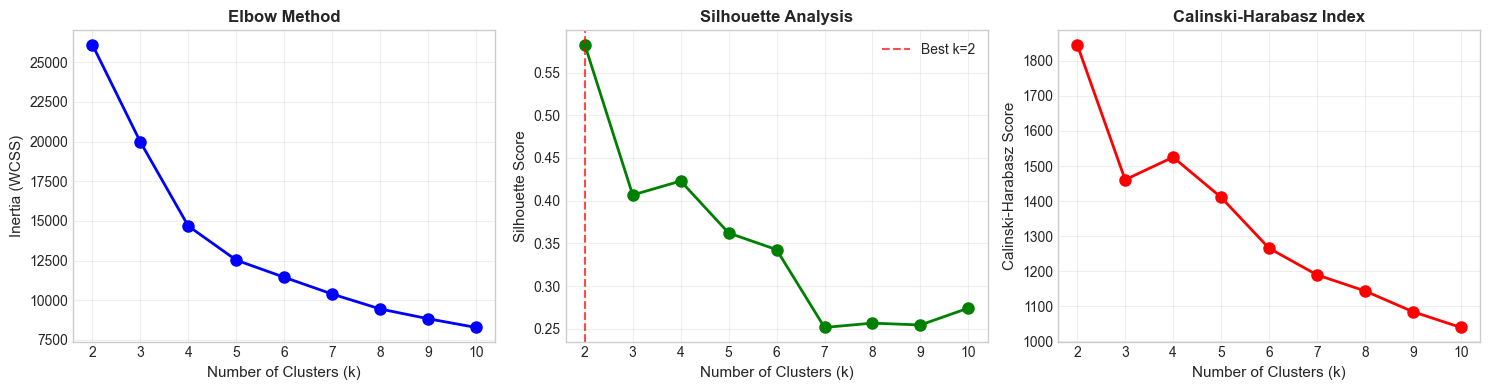


📊 Best k by Silhouette Score: 2
📊 Best k by Calinski-Harabasz: 2


In [6]:
# ==============================================================================
# VISUALIZE CLUSTER SELECTION METRICS
# ==============================================================================

# Create a figure with 3 subplots for different metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Plot 1: Elbow Method (Inertia) ---
axes[0].plot(K_RANGE, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0].set_xticks(list(K_RANGE))
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Silhouette Score ---
axes[1].plot(K_RANGE, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
axes[1].set_xticks(list(K_RANGE))
axes[1].grid(True, alpha=0.3)

# Highlight the best silhouette score
best_k_sil = list(K_RANGE)[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k_sil, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k_sil}')
axes[1].legend()

# --- Plot 3: Calinski-Harabasz Score ---
axes[2].plot(K_RANGE, calinski_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[2].set_title('Calinski-Harabasz Index', fontsize=12, fontweight='bold')
axes[2].set_xticks(list(K_RANGE))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/kmeans_cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Best k by Silhouette Score: {best_k_sil}")
print(f"📊 Best k by Calinski-Harabasz: {list(K_RANGE)[np.argmax(calinski_scores)]}")

## 4. Train Final K-Means Model

In [7]:
# ==============================================================================
# SELECT OPTIMAL NUMBER OF CLUSTERS
# ==============================================================================

# Based on the analysis above, we select the optimal number of clusters
# For market regimes, typically 3-5 clusters represent:
# - Bull market (strong growth)
# - Bear market (decline)
# - Sideways/consolidation
# - High volatility periods
# - Recovery phases

# Choose optimal k (can be adjusted based on Elbow/Silhouette analysis)
OPTIMAL_K = 4  # Typically 3-5 regimes work well for market analysis

print(f"Selected number of clusters: {OPTIMAL_K}")
print("\nExpected market regimes:")
print("  • Cluster 0: May represent one market state (e.g., bull market)")
print("  • Cluster 1: May represent another state (e.g., bear market)")
print("  • Cluster 2: May represent transition/consolidation periods")
print("  • Cluster 3: May represent high volatility/uncertainty")

Selected number of clusters: 4

Expected market regimes:
  • Cluster 0: May represent one market state (e.g., bull market)
  • Cluster 1: May represent another state (e.g., bear market)
  • Cluster 2: May represent transition/consolidation periods
  • Cluster 3: May represent high volatility/uncertainty


In [8]:
# ==============================================================================
# TRAIN FINAL K-MEANS MODEL
# ==============================================================================

# Initialize the final K-Means model with optimal k
kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,  # Number of clusters (market regimes)
    random_state=42,       # For reproducibility
    n_init=20,             # Run 20 times with different initializations
    max_iter=300,          # Maximum iterations per run
    tol=1e-4               # Convergence tolerance
)

# Fit the model and get cluster labels
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Display model summary
print("=" * 60)
print("FINAL K-MEANS MODEL SUMMARY")
print("=" * 60)
print(f"Number of clusters: {OPTIMAL_K}")
print(f"Inertia: {kmeans_final.inertia_:.2f}")
print(f"Iterations to converge: {kmeans_final.n_iter_}")
print(f"\nFinal Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.4f}")
print(f"Final Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, cluster_labels):.2f}")

FINAL K-MEANS MODEL SUMMARY
Number of clusters: 4
Inertia: 14678.88
Iterations to converge: 17

Final Silhouette Score: 0.4230
Final Calinski-Harabasz Score: 1525.27


In [9]:
# ==============================================================================
# ADD CLUSTER LABELS TO DATASET
# ==============================================================================

# Create a new DataFrame with cluster assignments
# This preserves the time index for temporal analysis
df_clustered = df.loc[X.index].copy()
df_clustered['cluster'] = cluster_labels

# Display cluster distribution
print("=" * 60)
print("CLUSTER DISTRIBUTION")
print("=" * 60)
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_clustered)) * 100
    print(f"Cluster {cluster_id}: {count:5d} samples ({pct:5.2f}%)")

print(f"\nTotal samples: {len(df_clustered)}")

CLUSTER DISTRIBUTION
Cluster 0:  1076 samples (64.51%)
Cluster 1:   284 samples (17.03%)
Cluster 2:   102 samples ( 6.12%)
Cluster 3:   206 samples (12.35%)

Total samples: 1668


## 5. Analyze Market Regimes

In [10]:
# ==============================================================================
# CLUSTER CHARACTERISTICS ANALYSIS
# ==============================================================================

# Analyze the key characteristics of each cluster/regime
# This helps interpret what each cluster represents in market terms

# Select key features to analyze (original, unscaled values)
KEY_FEATURES = ['SP500', 'Real Price', 'PE10', 'return_1m', 'return_3m', 
                'Long Interest Rate', 'Consumer Price Index']

# Filter to features that exist in our dataset
available_features = [f for f in KEY_FEATURES if f in df_clustered.columns]

# Calculate mean values for each cluster
cluster_stats = df_clustered.groupby('cluster')[available_features].mean()

print("=" * 60)
print("CLUSTER CHARACTERISTICS (Mean Values)")
print("=" * 60)
print(cluster_stats.round(4).to_string())

CLUSTER CHARACTERISTICS (Mean Values)
           SP500  Real Price    PE10  return_1m  return_3m  Long Interest Rate  Consumer Price Index
cluster                                                                                             
0        -0.3810     -0.2833  0.0420    -0.0052    -0.0110             -0.4207               -0.4218
1         1.9158      1.3305 -0.0608     0.0256     0.0517              1.6734                1.9337
2        35.8988     14.2416  2.2239     0.0713     0.1319             -0.9920                7.0661
3        13.7823      6.8304  1.8099     0.0530     0.0809             -0.1239                5.0741


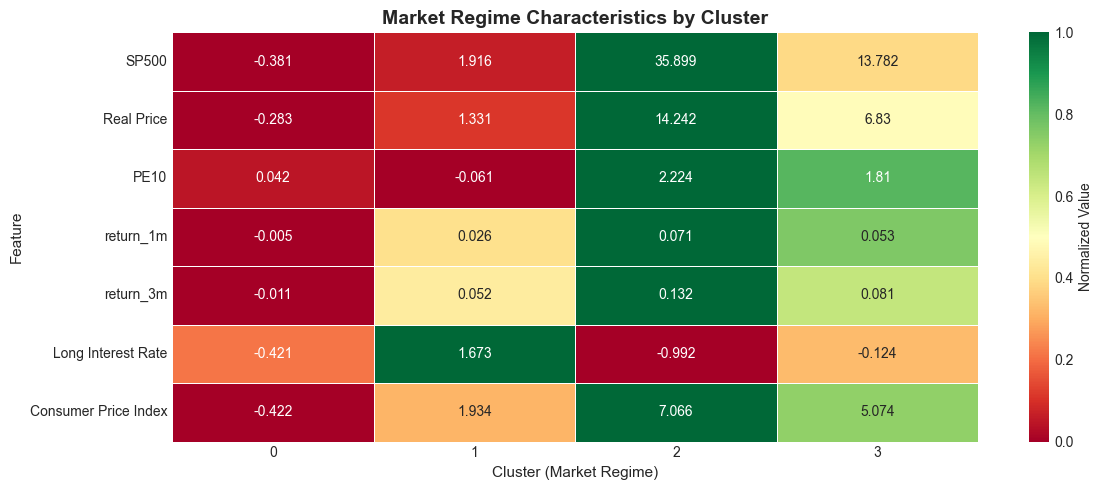

In [11]:
# ==============================================================================
# VISUALIZE CLUSTER CHARACTERISTICS
# ==============================================================================

# Create a heatmap showing normalized feature values per cluster
# This makes it easy to compare regimes across features

# Normalize cluster means for visualization (0-1 scale)
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

# Create heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(
    cluster_stats_norm.T,  # Transpose for better visualization
    annot=cluster_stats.T.round(3),  # Show actual values
    fmt='',
    cmap='RdYlGn',
    center=0.5,
    linewidths=0.5,
    cbar_kws={'label': 'Normalized Value'}
)
plt.title('Market Regime Characteristics by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster (Market Regime)', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.savefig('../docs/kmeans_cluster_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Visualize Cluster Transitions Over Time

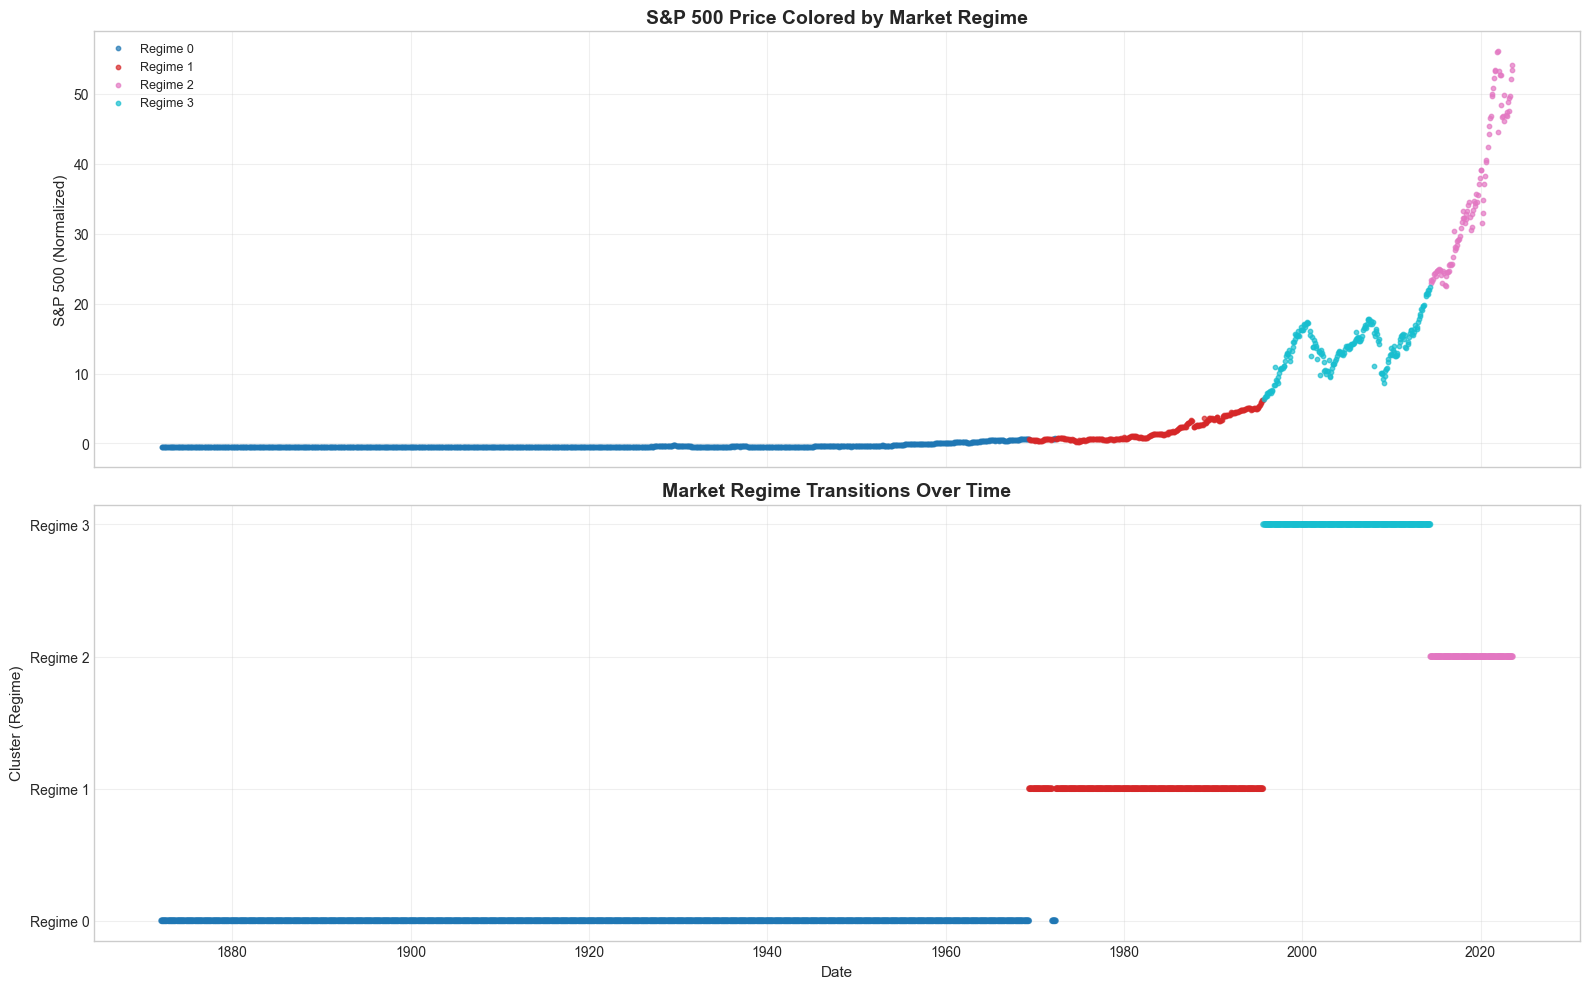

✅ Regime transition plots saved!


In [12]:
# ==============================================================================
# CLUSTER TRANSITIONS TIMELINE
# ==============================================================================

# Visualize how the market transitions between regimes over time
# This is crucial for understanding market cycle patterns

# Create figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# --- Plot 1: S&P 500 Price with Cluster Colors ---
# Create a scatter plot colored by cluster
colors = plt.cm.tab10(np.linspace(0, 1, OPTIMAL_K))

for cluster_id in range(OPTIMAL_K):
    mask = df_clustered['cluster'] == cluster_id
    axes[0].scatter(
        df_clustered.index[mask],
        df_clustered.loc[mask, 'SP500'],
        c=[colors[cluster_id]],
        s=10,
        alpha=0.7,
        label=f'Regime {cluster_id}'
    )

axes[0].set_ylabel('S&P 500 (Normalized)', fontsize=11)
axes[0].set_title('S&P 500 Price Colored by Market Regime', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Cluster Labels Over Time ---
axes[1].scatter(
    df_clustered.index,
    df_clustered['cluster'],
    c=df_clustered['cluster'],
    cmap='tab10',
    s=15,
    alpha=0.7
)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Cluster (Regime)', fontsize=11)
axes[1].set_title('Market Regime Transitions Over Time', fontsize=14, fontweight='bold')
axes[1].set_yticks(range(OPTIMAL_K))
axes[1].set_yticklabels([f'Regime {i}' for i in range(OPTIMAL_K)])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/kmeans_regime_transitions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Regime transition plots saved!")

In [13]:
# ==============================================================================
# REGIME DURATION ANALYSIS
# ==============================================================================

# Analyze how long each regime typically lasts
# This helps understand market cycle persistence

# Identify regime change points
df_clustered['regime_change'] = df_clustered['cluster'].diff().fillna(0) != 0

# Count regime transitions
n_transitions = df_clustered['regime_change'].sum()
print(f"Total regime transitions: {int(n_transitions)}")
print(f"Average regime duration: {len(df_clustered) / (n_transitions + 1):.1f} months")

# Calculate transitions between specific regimes
print("\n" + "=" * 60)
print("REGIME TRANSITION MATRIX")
print("=" * 60)

# Create transition matrix
df_clustered['next_cluster'] = df_clustered['cluster'].shift(-1)
transition_matrix = pd.crosstab(
    df_clustered['cluster'], 
    df_clustered['next_cluster'],
    normalize='index'
) * 100

print("\nTransition probabilities (%):\n")
print(transition_matrix.round(1).to_string())

Total regime transitions: 5
Average regime duration: 278.0 months

REGIME TRANSITION MATRIX

Transition probabilities (%):

next_cluster   0.0   1.0    2.0   3.0
cluster                              
0             99.8   0.2    0.0   0.0
1              0.4  99.3    0.0   0.4
2              0.0   0.0  100.0   0.0
3              0.0   0.0    0.5  99.5


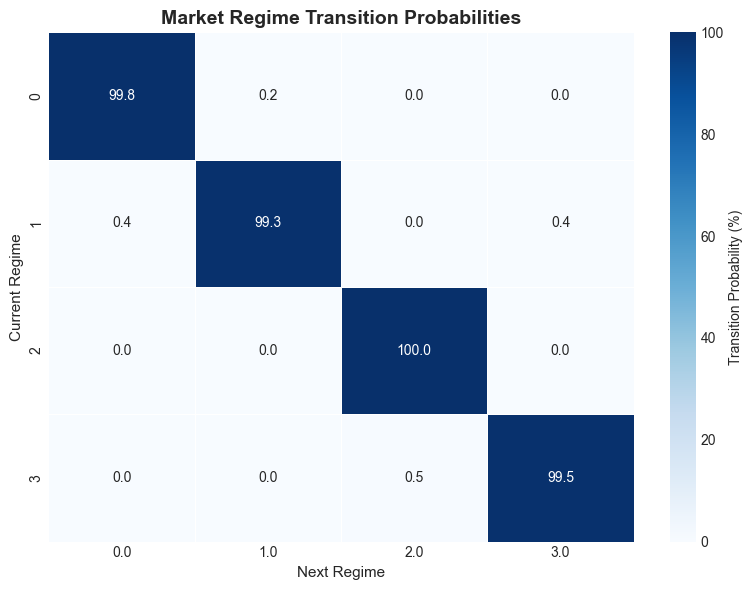

In [14]:
# ==============================================================================
# TRANSITION MATRIX HEATMAP
# ==============================================================================

# Visualize regime transition probabilities
plt.figure(figsize=(8, 6))
sns.heatmap(
    transition_matrix,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Transition Probability (%)'},
    linewidths=0.5
)
plt.title('Market Regime Transition Probabilities', fontsize=14, fontweight='bold')
plt.xlabel('Next Regime', fontsize=11)
plt.ylabel('Current Regime', fontsize=11)
plt.tight_layout()
plt.savefig('../docs/kmeans_transition_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. PCA Visualization of Clusters

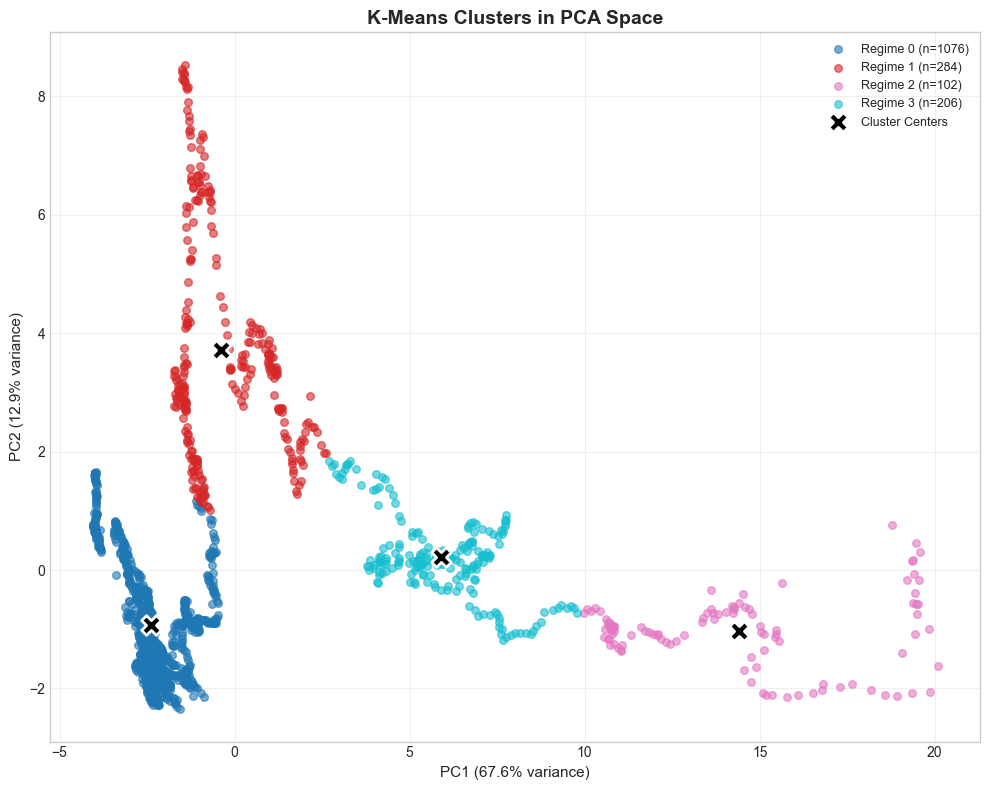


Total variance explained by PC1 + PC2: 80.5%


In [15]:
# ==============================================================================
# PCA 2D VISUALIZATION OF CLUSTERS
# ==============================================================================

# Reduce dimensions to 2D using PCA for visualization
# This helps visualize cluster separation in reduced feature space

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot each cluster with different colors
for cluster_id in range(OPTIMAL_K):
    mask = cluster_labels == cluster_id
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        c=[colors[cluster_id]],
        s=30,
        alpha=0.6,
        label=f'Regime {cluster_id} (n={mask.sum()})'
    )

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='black',
    s=200,
    marker='X',
    edgecolors='white',
    linewidths=2,
    label='Cluster Centers'
)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
plt.title('K-Means Clusters in PCA Space', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../docs/kmeans_pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal variance explained by PC1 + PC2: {sum(pca.explained_variance_ratio_[:2])*100:.1f}%")

## 8. Save Results

In [16]:
# ==============================================================================
# SAVE CLUSTERED DATASET
# ==============================================================================

# Save the dataset with cluster labels for future use
# This allows other analyses to use the regime classifications

# Define output path
OUTPUT_PATH = '../data/processed/processed_data_with_clusters.csv'

# Drop temporary columns used for analysis
df_export = df_clustered.drop(columns=['regime_change', 'next_cluster'], errors='ignore')

# Save to CSV
df_export.to_csv(OUTPUT_PATH)

print("=" * 60)
print("DATASET SAVED SUCCESSFULLY")
print("=" * 60)
print(f"Output file: {OUTPUT_PATH}")
print(f"Shape: {df_export.shape}")
print(f"\nNew column added: 'cluster' (market regime labels)")
print(f"Cluster values: {sorted(df_export['cluster'].unique())}")

DATASET SAVED SUCCESSFULLY
Output file: ../data/processed/processed_data_with_clusters.csv
Shape: (1668, 36)

New column added: 'cluster' (market regime labels)
Cluster values: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]


In [17]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("=" * 70)
print("US-08: K-MEANS MARKET REGIME CLUSTERING - SUMMARY")
print("=" * 70)

print("\n📊 CLUSTERING RESULTS:")
print(f"   • Number of market regimes identified: {OPTIMAL_K}")
print(f"   • Total data points clustered: {len(df_clustered)}")
print(f"   • Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.4f}")
print(f"   • Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, cluster_labels):.2f}")

print("\n📈 CLUSTER DISTRIBUTION:")
for cluster_id, count in cluster_counts.items():
    pct = (count / len(df_clustered)) * 100
    print(f"   • Regime {cluster_id}: {count} samples ({pct:.1f}%)")

print("\n📁 SAVED FILES:")
print("   • Clustered data: data/processed/processed_data_with_clusters.csv")
print("   • Cluster selection plot: docs/kmeans_cluster_selection.png")
print("   • Cluster characteristics: docs/kmeans_cluster_characteristics.png")
print("   • Regime transitions: docs/kmeans_regime_transitions.png")
print("   • Transition matrix: docs/kmeans_transition_matrix.png")
print("   • PCA visualization: docs/kmeans_pca_visualization.png")

print("\n✅ ACCEPTANCE CRITERIA MET:")
print("   ✓ Notebook: 06_kmeans.ipynb")
print("   ✓ Cluster labels added to dataset")
print("   ✓ Visual plots of cluster transitions over time")
print("\n" + "=" * 70)

US-08: K-MEANS MARKET REGIME CLUSTERING - SUMMARY

📊 CLUSTERING RESULTS:
   • Number of market regimes identified: 4
   • Total data points clustered: 1668
   • Silhouette Score: 0.4230
   • Calinski-Harabasz Score: 1525.27

📈 CLUSTER DISTRIBUTION:
   • Regime 0: 1076 samples (64.5%)
   • Regime 1: 284 samples (17.0%)
   • Regime 2: 102 samples (6.1%)
   • Regime 3: 206 samples (12.4%)

📁 SAVED FILES:
   • Clustered data: data/processed/processed_data_with_clusters.csv
   • Cluster selection plot: docs/kmeans_cluster_selection.png
   • Cluster characteristics: docs/kmeans_cluster_characteristics.png
   • Regime transitions: docs/kmeans_regime_transitions.png
   • Transition matrix: docs/kmeans_transition_matrix.png
   • PCA visualization: docs/kmeans_pca_visualization.png

✅ ACCEPTANCE CRITERIA MET:
   ✓ Notebook: 06_kmeans.ipynb
   ✓ Cluster labels added to dataset
   ✓ Visual plots of cluster transitions over time

